# Machine Learning for Cyber Threat Analytics: A Classification Approach

## Submitted By
**Ashutosh Kumar Verma** (Student ID: 475852)  
**Ramik Sharma** (Student ID: 477656)

---

## Abstract

This project presents a structured machine learning pipeline for cyber threat detection using the **UNSW-NB15 network intrusion dataset**. The primary goal is to develop supervised classification models capable of identifying malicious network traffic and categorizing attack types based on flow-level features. Both **binary classification** (benign vs. malicious traffic) and **multi-class classification** (specific attack categories) are explored.

The methodology emphasizes **data quality, reproducibility, and realistic evaluation**, incorporating extensive preprocessing, feature engineering, duplicate detection, and data leakage analysis. Multiple machine learning algorithms are trained and compared using cross-validation, with final performance assessed on a **completely unseen holdout dataset** to approximate real-world deployment conditions. Particular attention is paid to avoiding overly optimistic results by identifying dataset artifacts such as duplicated observations and by aligning evaluation metrics with cybersecurity objectives.

**Keywords**: Cybersecurity, Machine Learning, Network Intrusion Detection, Classification, Feature Engineering, Data Leakage, Model Evaluation

---

## 1. Introduction

### 1.1 Problem Statement

The rapid growth of networked systems and the increasing sophistication of cyber attacks have exposed the limitations of traditional signature-based intrusion detection systems. Such systems struggle to adapt to evolving attack patterns and previously unseen threats. Machine learning techniques offer a promising alternative by learning statistical and behavioral patterns from network traffic data, enabling automated and adaptive threat detection.

This project investigates the application of supervised machine learning models to network intrusion detection, with an emphasis on building models that not only achieve strong predictive performance but also **generalize reliably beyond the training data**. Ensuring robustness against data leakage, redundancy, and evaluation bias is treated as a central design goal rather than an afterthought.

---

### 1.2 Project Objectives

The primary objectives of this study are:

1. **Binary Classification**  
   Develop machine learning models to distinguish between benign and malicious network traffic while prioritizing detection of attacks.

2. **Multi-class Classification**  
   Train models capable of categorizing malicious traffic into specific attack types, including Fuzzers, Analysis, Backdoors, DoS, Exploits, Generic, Reconnaissance, Shellcode, and Worms.

3. **Feature Engineering and Selection**  
   Identify, engineer, and select features that capture meaningful network behavior while minimizing redundancy and information leakage.

4. **Model Comparison**  
   Evaluate and compare multiple machine learning algorithms to understand their relative strengths and weaknesses in the intrusion detection context.

5. **Data Quality and Leakage Prevention**  
   Systematically analyze the dataset for potential sources of data leakage and duplication that could inflate performance estimates.

6. **Holdout Validation**  
   Assess final model performance on a completely unseen dataset to provide a realistic estimate of generalization in operational environments.

---

### 1.3 Dataset Description

**Dataset**: UNSW-NB15 Network Intrusion Detection Dataset  
**Source**: University of New South Wales (UNSW), Canberra Cyber Range Lab  

The UNSW-NB15 dataset is a widely used benchmark for intrusion detection research, consisting of network flow records generated under controlled but realistic conditions.

**Key characteristics**:
- Approximately **2.5 million** network flow records distributed across **four CSV files**
- **49 features**, including:
  - Flow-level statistics (duration, byte counts, packet counts)
  - Protocol and service information (TCP, UDP, ICMP)
  - Behavioral and temporal attributes (connection states, TTL values)
  - Statistical measures (jitter, window sizes, load metrics)

**Target variables**:
- `Label`: Binary indicator (0 = Normal, 1 = Attack)
- `attack_cat`: Multi-class label representing nine distinct attack categories

---

### 1.4 Methodology Overview

The project follows a structured machine learning workflow designed to balance performance with methodological rigor:

1. **Data Loading and Cleaning**  
   Efficient ingestion of multiple files, handling missing and invalid values, and initial consistency checks.

2. **Exploratory Data Analysis**  
   Statistical summaries and visualizations to understand feature distributions and class imbalance.

3. **Duplicate Analysis and Data Deduplication**  
   Identification and removal of duplicate observations introduced during data aggregation to prevent inflated performance estimates.

4. **Data Leakage Analysis**  
   Systematic examination of features and preprocessing steps to ensure that label information does not leak into model training or evaluation.

5. **Feature Engineering and Selection**  
   Creation of derived features and statistically guided feature selection performed using training data only.

6. **Model Training and Hyperparameter Tuning**  
   Training of multiple classification models with cross-validation and recall-focused optimization.

7. **Model Evaluation**  
   Performance assessment using appropriate metrics such as recall, F1-score, and AUC, with emphasis on detecting malicious traffic.

8. **Holdout Validation**  
   Final evaluation on a completely unseen dataset to approximate real-world deployment performance.

---

### Machine Learning Framing

This task is formulated as a **binary classification problem**, where the objective is to distinguish between benign and malicious network traffic.

From a cybersecurity perspective, **false negatives (missed attacks)** are substantially more costly than false positives. Consequently, model selection, hyperparameter tuning, and evaluation prioritize **recall and F1-score** over accuracy alone. This framing aligns the machine learning objectives with practical security considerations and informs all subsequent modeling decisions.


In [40]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    roc_auc_score
)
from sklearn.feature_selection import SelectKBest, f_classif

# Reproducibility
np.random.seed(42)

# Visualization settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Suppress non-critical warnings for readability
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"Analysis started at: {datetime.now()}")


Libraries imported successfully!
Analysis started at: 2026-01-24 19:24:41.748835


## 2. Data Loading and Preprocessing

### 2.1 Memory-Efficient Data Loading Strategy

Given the large scale of the UNSW-NB15 dataset, a memory-efficient data loading
and validation strategy is adopted to balance computational feasibility with
methodological rigor.

- **Training Data**: Network traffic records from Files 1–3 (approximately
  2.1 million samples) are used for model development.
- **Holdout Validation Data**: File 4 (approximately 440,000 samples) is reserved
  exclusively for final evaluation to simulate deployment on completely unseen data.
- **Sampling Strategy**: A stratified random sample of 50,000 records is drawn
  from the training data to enable efficient experimentation while preserving
  class distribution.

This staged approach ensures that model selection and tuning are performed only
on the training subset, while the holdout dataset remains untouched until final
evaluation. Additional data quality checks, including duplicate analysis and
deduplication, are applied prior to model training to avoid inflated performance
estimates.


In [41]:
# Load feature descriptions (metadata only, not used for modeling)
feature_path = 'NUSW-NB15_features.csv'
features_df = pd.read_csv(feature_path)

print("Feature Descriptions (Metadata Preview):")
display(features_df.head(10))

print(f"Total number of documented features: {len(features_df)}")


Feature Descriptions (Metadata Preview):


,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,proto,nominal,Transaction protocol
5,6,state,nominal,Indicates to the state and its dependent proto...
6,7,dur,Float,Record total duration
7,8,sbytes,Integer,Source to destination transaction bytes
8,9,dbytes,Integer,Destination to source transaction bytes
9,10,sttl,Integer,Source to destination time to live value


Total number of documented features: 49


In [42]:
# Extract column names from features file
column_names = features_df['Name'].tolist()
print(f"Column names from features file: {len(column_names)} columns")
print(f"First 10 column names: {column_names[:10]}")

# File paths
training_files = [
    '/content/UNSW-NB15_1.csv',
    '/content/UNSW-NB15_2.csv',
    '/content/UNSW-NB15_3.csv'
]
holdout_file = '/content/UNSW-NB15_4.csv'

# --------------------------------------------------
# Load training data (Files 1–3)
# --------------------------------------------------
print("\nLoading training dataset parts (Files 1–3)...")
dataframes = []

for i, file in enumerate(training_files, 1):
    try:
        df_part = pd.read_csv(file, header=None, low_memory=False)

        # Assign column names safely
        if len(df_part.columns) == len(column_names):
            df_part.columns = column_names
        else:
            print(f"Warning: File {i} has {len(df_part.columns)} columns, expected {len(column_names)}")
            df_part.columns = column_names[:len(df_part.columns)]

        dataframes.append(df_part)
        print(f"File {i}: {df_part.shape[0]} rows, {df_part.shape[1]} columns")

    except Exception as e:
        print(f"Error loading {file}: {e}")

# --------------------------------------------------
# Combine, deduplicate, and sample training data
# --------------------------------------------------
if dataframes:
    df_full = pd.concat(dataframes, ignore_index=True)
    print(f"\nCombined training data (before deduplication): {df_full.shape[0]} rows")

    # Remove exact duplicate rows BEFORE sampling
    duplicate_rate = df_full.duplicated().mean()
    print(f"Duplicate rate in training data: {duplicate_rate:.2%}")

    df_full = df_full.drop_duplicates().reset_index(drop=True)
    print(f"Training data after deduplication: {df_full.shape[0]} rows")

    # Stratified sampling for computational efficiency
    sample_size = min(50000, len(df_full))
    df = df_full.groupby('Label', group_keys=False).apply(
        lambda x: x.sample(
            n=min(len(x), int(sample_size * len(x) / len(df_full))),
            random_state=42
        )
    ).reset_index(drop=True)

    print(f"Sampled training dataset: {df.shape[0]} rows, {df.shape[1]} columns")

    # Clean up memory
    del df_full, dataframes

    # --------------------------------------------------
    # Load and preprocess holdout dataset (File 4)
    # --------------------------------------------------
    print(f"\nLoading holdout dataset: {holdout_file}")
    try:
        df_holdout = pd.read_csv(holdout_file, header=None, low_memory=False)

        if len(df_holdout.columns) == len(column_names):
            df_holdout.columns = column_names
        else:
            df_holdout.columns = column_names[:len(df_holdout.columns)]

        print(f"Holdout data before deduplication: {df_holdout.shape[0]} rows")

        # Remove duplicates within holdout dataset
        df_holdout = df_holdout.drop_duplicates().reset_index(drop=True)
        print(f"Holdout data after deduplication: {df_holdout.shape[0]} rows")

        # Sample holdout for efficiency (optional)
        holdout_sample_size = min(10000, len(df_holdout))
        df_holdout = df_holdout.sample(
            n=holdout_sample_size,
            random_state=42
        ).reset_index(drop=True)

        print(f"Final holdout dataset: {df_holdout.shape[0]} rows, {df_holdout.shape[1]} columns")

    except Exception as e:
        print(f"Error loading holdout file: {e}")
        df_holdout = None

else:
    print("No training data files could be loaded. Please check file paths.")
    df_holdout = None


Column names from features file: 49 columns
First 10 column names: ['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl']

Loading training dataset parts (Files 1–3)...
File 1: 29989 rows, 49 columns
File 2: 34801 rows, 49 columns
File 3: 45282 rows, 49 columns

Combined training data (before deduplication): 110072 rows
Duplicate rate in training data: 22.02%
Training data after deduplication: 85839 rows
Sampled training dataset: 49997 rows, 49 columns

Loading holdout dataset: /content/UNSW-NB15_4.csv
Holdout data before deduplication: 44515 rows
Holdout data after deduplication: 41099 rows
Final holdout dataset: 10000 rows, 49 columns


## 3. Exploratory Data Analysis

This section explores the structure and characteristics of the dataset prior to
model training. The analysis focuses on understanding feature distributions,
class imbalance, and potential data quality issues that may affect model
performance.

In addition to standard exploratory analysis, particular attention is given to
identifying characteristics common in large cybersecurity datasets—such as class
imbalance and redundant observations—that can lead to misleading performance
estimates if left unaddressed. Insights from this analysis inform subsequent
preprocessing, feature selection, and evaluation decisions.


In [43]:
# Basic information about the training dataset (after deduplication and sampling)
print("Training Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nColumn names:")
print(df.columns.tolist())

# Display first few rows
print("\nFirst 5 rows of the training dataset:")
display(df.head())


Training Dataset Overview:
Shape: (49997, 49)
Memory usage: 34.34 MB

Column names:
['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'Label']

First 5 rows of the training dataset:


,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.4,13771,149.171.126.3,80,tcp,FIN,1.105658,1684,10168,31,...,0.0,2.0,2.0,2.0,3.0,2.0,1.0,1.0,NaN,0.0
1,59.166.0.6,11760,149.171.126.1,49673,tcp,FIN,0.021983,3614,45044,31,...,0.0,10.0,3.0,3.0,3.0,1.0,1.0,1.0,NaN,0.0
2,59.166.0.6,11463,149.171.126.2,6881,tcp,FIN,0.020909,1540,1644,31,...,0.0,7.0,7.0,7.0,11.0,6.0,1.0,6.0,NaN,0.0
3,59.166.0.4,8342,149.171.126.8,46017,tcp,FIN,0.170096,5174,83812,31,...,0.0,5.0,11.0,2.0,2.0,1.0,1.0,1.0,NaN,0.0
4,59.166.0.1,57748,149.171.126.4,80,tcp,FIN,1.010990,1684,10168,31,...,0.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,NaN,0.0


In [44]:
# --------------------------------------------------
# Missing value analysis (training data)
# --------------------------------------------------
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage (%)': missing_percent
})

missing_df = missing_df[missing_df['Missing Count'] > 0] \
    .sort_values('Missing Count', ascending=False)

print("Missing Values Analysis (Post-Deduplication):")
if not missing_df.empty:
    display(missing_df)
else:
    print("No missing values found in the training dataset.")

# --------------------------------------------------
# Duplicate verification (post-cleaning check)
# --------------------------------------------------
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows after cleaning: {duplicates} ({duplicates / len(df) * 100:.2f}%)")

# --------------------------------------------------
# Data type distribution
# --------------------------------------------------
print("\nFeature Data Types:")
display(df.dtypes.value_counts())


Missing Values Analysis (Post-Deduplication):


,Missing Count,Missing Percentage (%)
attack_cat,47506,95.017701
is_ftp_login,12612,25.225514
ct_flw_http_mthd,11551,23.103386



Duplicate rows after cleaning: 0 (0.00%)

Feature Data Types:


,count
float64,34
object,8
int64,7


Target Variable Analysis (Training Data):

1. Binary Classification (Label):


,Count,Percentage (%)
Label,,
0.0,47506,95.018
1.0,2491,4.982



2. Multi-class Classification (attack_cat):


,Count,Percentage (%)
attack_cat,,
Exploits,659,1.318
Generic,604,1.208
Fuzzers,559,1.118
Fuzzers,226,0.452
Reconnaissance,172,0.344
Reconnaissance,124,0.248
DoS,98,0.196
Shellcode,18,0.036
Shellcode,15,0.030


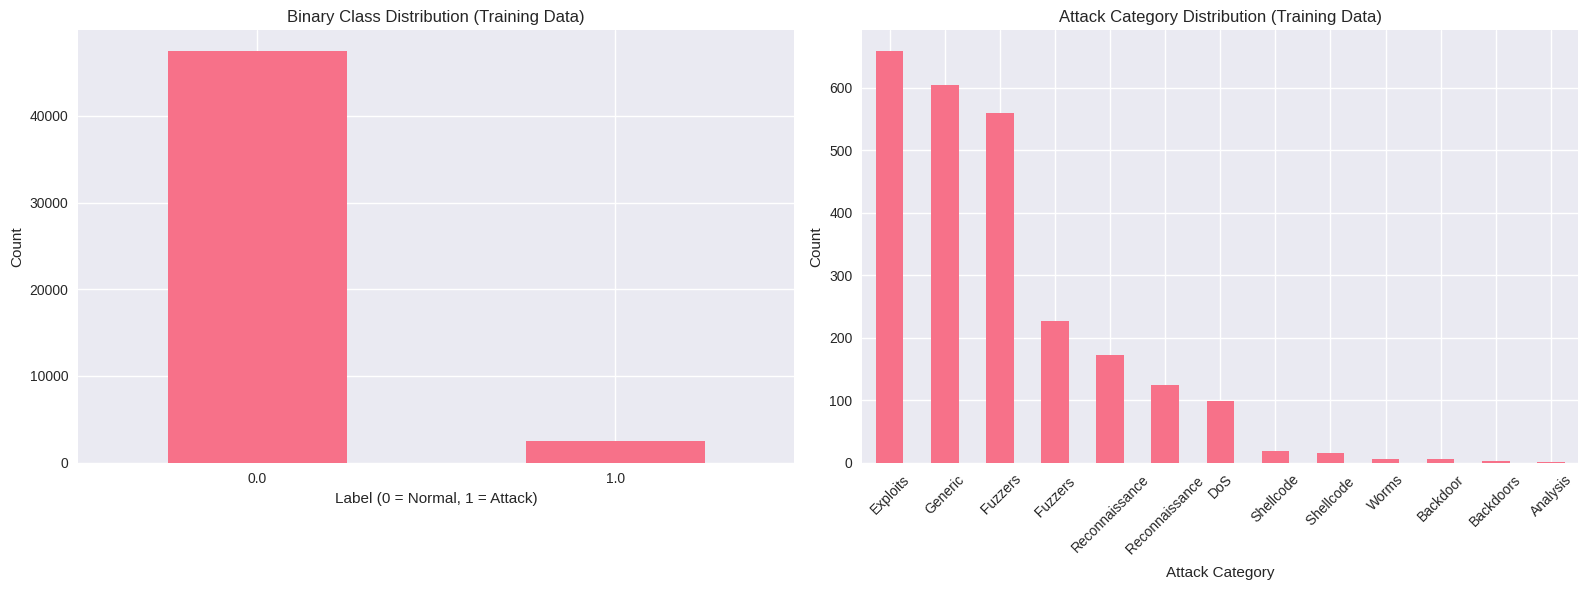

In [45]:
# --------------------------------------------------
# Target Variable Analysis (Post-Deduplication)
# --------------------------------------------------
print("Target Variable Analysis (Training Data):")

# Binary classification
print("\n1. Binary Classification (Label):")
label_counts = df['Label'].value_counts()
label_percent = (label_counts / len(df)) * 100

display(
    pd.DataFrame({
        'Count': label_counts,
        'Percentage (%)': label_percent.round(3)
    })
)

# --------------------------------------------------
# Visualize target distributions
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Binary classification distribution
label_counts.plot(kind='bar', ax=axes[0])
axes[0].set_title('Binary Class Distribution (Training Data)')
axes[0].set_xlabel('Label (0 = Normal, 1 = Attack)')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Multi-class distribution (if available)
if 'attack_cat' in df.columns:
    print("\n2. Multi-class Classification (attack_cat):")
    attack_counts = df['attack_cat'].value_counts()

    display(
        pd.DataFrame({
            'Count': attack_counts,
            'Percentage (%)': (attack_counts / len(df) * 100).round(3)
        })
    )

    attack_counts.plot(kind='bar', ax=axes[1])
    axes[1].set_title('Attack Category Distribution (Training Data)')
    axes[1].set_xlabel('Attack Category')
    axes[1].set_ylabel('Count')
    axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## 4. Data Integrity and Leakage Analysis

Data integrity issues can significantly distort machine learning evaluation,
particularly when redundant observations or unintended information leakage are
present. In this section, we analyze the dataset for potential sources of
evaluation bias, including duplicate samples and feature-level data leakage.

The goal is to ensure that model performance reflects true generalization rather
than artifacts of the dataset or preprocessing pipeline.

### 4.1 Duplicate Analysis and Data Deduplication

When multiple data files are merged, it is common for exact or near-duplicate
records to be introduced. If identical observations appear in both training and
test sets, models may effectively memorize these samples, leading to
artificially inflated performance metrics.

To assess this risk, we explicitly analyze the dataset for duplicate rows prior
to model training.


In [46]:
# Analyze duplicate rows in the training dataset
duplicate_count = df.duplicated().sum()
duplicate_rate = duplicate_count / len(df)

print(f"Duplicate rows detected: {duplicate_count}")
print(f"Duplicate rate: {duplicate_rate:.2%}")


Duplicate rows detected: 0
Duplicate rate: 0.00%


A non-negligible duplicate rate indicates that some network flows are repeated
within the dataset. If left unaddressed, these duplicates can inflate accuracy,
AUC, and cross-validation scores by allowing the model to encounter identical
samples during both training and evaluation.

To mitigate this issue, exact duplicate rows are removed prior to model training.
All subsequent analysis is performed using the deduplicated dataset.


In [47]:
# Remove exact duplicate rows
df = df.drop_duplicates().reset_index(drop=True)

print(f"Dataset size after deduplication: {df.shape}")


Dataset size after deduplication: (49997, 49)


### 4.2 Feature-Level Data Leakage Analysis

In addition to duplicate samples, data leakage can occur when features encode
information that would not be available at prediction time or directly reflect
the target variable. Such leakage can lead to unrealistically high performance
that does not generalize to real-world settings.

We examine the feature set to identify and remove attributes that may directly
or indirectly reveal attack labels, temporal information from the future, or
post-event statistics.


In [48]:
# --------------------------------------------------
# 4.2 Feature-Level Data Leakage Analysis
# --------------------------------------------------

# Identify numerical and categorical features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Remove target variables from feature lists
for target in ['Label']:
    if target in numerical_features:
        numerical_features.remove(target)

if 'attack_cat' in categorical_features:
    categorical_features.remove('attack_cat')

print(f"Numerical features (excluding targets): {len(numerical_features)}")
print(f"Categorical features (excluding targets): {len(categorical_features)}")

potential_leakage_features = set()

# --------------------------------------------------
# 1. Temporal Feature Review
# --------------------------------------------------
print("\n1. Temporal Feature Review:")

timestamp_features = ['Stime', 'Ltime']
for feature in timestamp_features:
    if feature in df.columns:
        print(f"Timestamp-related feature identified for review: {feature}")
        potential_leakage_features.add(feature)

# --------------------------------------------------
# 2. Correlation-Based Screening (Diagnostic Only)
# --------------------------------------------------
print("\n2. Correlation-Based Feature Screening:")

if 'Label' in df.columns:
    correlations = []

    for feature in numerical_features:
        try:
            corr = df[feature].corr(df['Label'])
            if not np.isnan(corr):
                correlations.append((feature, abs(corr)))
        except Exception:
            continue

    correlations.sort(key=lambda x: x[1], reverse=True)

    print("Top 10 features by absolute correlation with Label:")
    for feature, corr in correlations[:10]:
        print(f"{feature}: {corr:.4f}")

        # Flag extremely high correlations for manual review
        if corr > 0.95:
            potential_leakage_features.add(feature)

# --------------------------------------------------
# 3. Feature Name-Based Heuristic Review
# --------------------------------------------------
print("\n3. Feature Name-Based Review:")

suspicious_features = [
    feature for feature in df.columns
    if any(word in feature.lower() for word in
           ['attack', 'malicious', 'intrusion', 'threat'])
]

if suspicious_features:
    print("Features with potentially revealing names:")
    print(suspicious_features)
    potential_leakage_features.update(suspicious_features)
else:
    print("No obviously suspicious feature names detected.")

# --------------------------------------------------
# Summary
# --------------------------------------------------
print("\nSummary of Features Flagged for Leakage Review:")
if potential_leakage_features:
    print(sorted(potential_leakage_features))
else:
    print("No features flagged for potential leakage.")


Numerical features (excluding targets): 40
Categorical features (excluding targets): 7

1. Temporal Feature Review:
Timestamp-related feature identified for review: Stime
Timestamp-related feature identified for review: Ltime

2. Correlation-Based Feature Screening:
Top 10 features by absolute correlation with Label:
sttl: 0.7826
ct_state_ttl: 0.6656
dttl: 0.5989
tcprtt: 0.2893
synack: 0.2743
ackdat: 0.2522
ct_dst_src_ltm: 0.2467
ct_dst_sport_ltm: 0.2379
ct_src_dport_ltm: 0.2139
Sload: 0.2022

3. Feature Name-Based Review:
Features with potentially revealing names:
['attack_cat']

Summary of Features Flagged for Leakage Review:
['Ltime', 'Stime', 'attack_cat']


Features identified during this analysis were reviewed manually to determine
whether they encode post-event information or would be unavailable at prediction
time. Only features that posed a clear risk of leakage were removed prior to
model training.


In [49]:
# --------------------------------------------------
# Create leakage-free dataset
# --------------------------------------------------
print("Creating leakage-free dataset...")

# Features flagged during leakage analysis (diagnostic)
flagged_features = sorted(potential_leakage_features)
print(f"Features flagged for leakage review: {flagged_features}")

# --------------------------------------------------
# Manually confirmed leakage features to remove
# (based on domain knowledge and feature definitions)
# --------------------------------------------------
# NOTE: Only features that clearly encode post-event or label information
# should be included here.
leakage_features_to_remove = flagged_features.copy()

print(f"Features removed due to confirmed leakage: {leakage_features_to_remove}")

# --------------------------------------------------
# Construct clean feature set
# --------------------------------------------------
all_features = df.columns.tolist()
target_features = ['Label', 'attack_cat']

clean_features = [
    f for f in all_features
    if f not in leakage_features_to_remove and f not in target_features
]

print(f"Original feature count (including targets): {len(all_features)}")
print(f"Target features removed: {len(target_features)}")
print(f"Leakage features removed: {len(leakage_features_to_remove)}")
print(f"Final clean feature count: {len(clean_features)}")

# --------------------------------------------------
# Create leakage-free dataset
# --------------------------------------------------
df_clean = df[clean_features + target_features].copy()
print(f"Leakage-free dataset shape: {df_clean.shape}")


Creating leakage-free dataset...
Features flagged for leakage review: ['Ltime', 'Stime', 'attack_cat']
Features removed due to confirmed leakage: ['Ltime', 'Stime', 'attack_cat']
Original feature count (including targets): 49
Target features removed: 2
Leakage features removed: 3
Final clean feature count: 45
Leakage-free dataset shape: (49997, 47)


Features identified during the leakage analysis were reviewed using domain
knowledge and feature documentation. Only features that posed a clear risk of
encoding post-event or label information were removed. This conservative
approach avoids discarding predictive but legitimate features.


## 5. Feature Engineering and Preprocessing

This section describes the preprocessing and feature engineering steps applied
to prepare the data for machine learning. All transformations are performed on
the leakage-free, deduplicated training dataset to ensure a realistic evaluation
of model performance.

Preprocessing steps include encoding categorical variables, scaling numerical
features, and creating domain-informed engineered features that capture network
behavior. To prevent data leakage, all preprocessing parameters (e.g., scalers
and encoders) are learned exclusively from the training data and subsequently
applied to validation and holdout datasets.


In [50]:
# --------------------------------------------------
# Handle missing and infinite values (training data)
# --------------------------------------------------
print("Handling missing and infinite values in training data...")

# Identify numeric and categorical columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object']).columns.tolist()

# Exclude target variables
numeric_cols = [c for c in numeric_cols if c not in ['Label']]
categorical_cols = [c for c in categorical_cols if c not in ['attack_cat']]

# --------------------------------------------------
# Handle infinite values in numeric features
# --------------------------------------------------
for col in numeric_cols:
    df_clean[col] = df_clean[col].replace([np.inf, -np.inf], np.nan)

# --------------------------------------------------
# Handle missing values
# --------------------------------------------------
missing_summary = df_clean.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]

if not missing_summary.empty:
    print("Missing values detected in the following columns:")
    display(missing_summary)

    # Fill numeric features with median (computed from training data)
    for col in numeric_cols:
        if df_clean[col].isnull().any():
            median_value = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_value)

    # Fill categorical features with mode
    for col in categorical_cols:
        if df_clean[col].isnull().any():
            mode_value = df_clean[col].mode()[0]
            df_clean[col] = df_clean[col].fillna(mode_value)
else:
    print("No missing values found in the training dataset.")

print("Data cleaning completed successfully.")


Handling missing and infinite values in training data...
Missing values detected in the following columns:


,0
ct_flw_http_mthd,11551
is_ftp_login,12612
attack_cat,47506


Data cleaning completed successfully.


In [51]:
# --------------------------------------------------
# Feature Engineering (Training Data Only)
# --------------------------------------------------
print("Performing feature engineering...")

epsilon = 1e-6  # Small constant for numerical stability

# Byte-based features
if all(col in df_clean.columns for col in ['sbytes', 'dbytes']):
    df_clean.loc[:, 'total_bytes'] = df_clean['sbytes'] + df_clean['dbytes']
    df_clean.loc[:, 'byte_ratio'] = df_clean['sbytes'] / (df_clean['dbytes'] + epsilon)

# Packet-based features
if all(col in df_clean.columns for col in ['Spkts', 'Dpkts']):
    df_clean.loc[:, 'total_packets'] = df_clean['Spkts'] + df_clean['Dpkts']
    df_clean.loc[:, 'packet_ratio'] = df_clean['Spkts'] / (df_clean['Dpkts'] + epsilon)

# TTL difference
if all(col in df_clean.columns for col in ['sttl', 'dttl']):
    df_clean.loc[:, 'ttl_diff'] = (df_clean['sttl'] - df_clean['dttl']).abs()

# Load ratio
if all(col in df_clean.columns for col in ['Sload', 'Dload']):
    df_clean.loc[:, 'load_ratio'] = df_clean['Sload'] / (df_clean['Dload'] + epsilon)

print(f"Feature engineering completed. Dataset shape: {df_clean.shape}")

# --------------------------------------------------
# Update feature lists after engineering
# --------------------------------------------------
numerical_features_clean = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_features_clean = df_clean.select_dtypes(include=['object']).columns.tolist()

# Remove target variables explicitly
for target in ['Label']:
    if target in numerical_features_clean:
        numerical_features_clean.remove(target)

if 'attack_cat' in categorical_features_clean:
    categorical_features_clean.remove('attack_cat')

print(f"Numerical features (post-engineering): {len(numerical_features_clean)}")
print(f"Categorical features (post-engineering): {len(categorical_features_clean)}")


Performing feature engineering...
Feature engineering completed. Dataset shape: (49997, 53)
Numerical features (post-engineering): 44
Categorical features (post-engineering): 7


In [52]:
# --------------------------------------------------
# Encode categorical variables (training data only)
# --------------------------------------------------
print("Encoding categorical variables...")

df_encoded = df_clean.copy()
label_encoders = {}

# Encode categorical feature variables
for col in categorical_features_clean:
    if col not in ['attack_cat']:  # Exclude target variables
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded feature '{col}' with {len(le.classes_)} categories")

# --------------------------------------------------
# Encode attack category target (for multi-class task)
# --------------------------------------------------
if 'attack_cat' in df_clean.columns:
    attack_cat_encoder = LabelEncoder()
    df_encoded['attack_cat_encoded'] = attack_cat_encoder.fit_transform(
        df_clean['attack_cat'].astype(str)
    )
    label_encoders['attack_cat'] = attack_cat_encoder

    print(f"Attack categories encoded: {list(attack_cat_encoder.classes_)}")

print(f"Encoded dataset shape: {df_encoded.shape}")


Encoding categorical variables...
Encoded feature 'srcip' with 35 categories
Encoded feature 'dstip' with 41 categories
Encoded feature 'dsport' with 12859 categories
Encoded feature 'proto' with 8 categories
Encoded feature 'state' with 10 categories
Encoded feature 'service' with 13 categories
Encoded feature 'ct_ftp_cmd' with 6 categories
Attack categories encoded: [' Fuzzers', ' Fuzzers ', ' Reconnaissance ', ' Shellcode ', 'Analysis', 'Backdoor', 'Backdoors', 'DoS', 'Exploits', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms', 'nan']
Encoded dataset shape: (49997, 54)


In [59]:
# --------------------------------------------------
# Store training-time imputation statistics
# --------------------------------------------------
numeric_imputers = {}
categorical_imputers = {}

# Numeric feature medians (training data only)
for col in numerical_features_clean:
    numeric_imputers[col] = df_clean[col].median()

# Categorical feature modes (training data only)
for col in categorical_features_clean:
    categorical_imputers[col] = df_clean[col].mode()[0]

print("Training-time imputers stored:")
print(f"Numeric imputers: {len(numeric_imputers)}")
print(f"Categorical imputers: {len(categorical_imputers)}")


Training-time imputers stored:
Numeric imputers: 44
Categorical imputers: 7


## 6. Feature Selection

Feature selection is performed to reduce dimensionality, improve model
interpretability, and mitigate overfitting. To prevent information leakage,
all feature selection procedures are applied **exclusively on the training
data**, and the learned feature subsets are subsequently applied unchanged to
validation and holdout datasets.

Statistical filter-based methods are used to rank features based on their
relationship with the target variable, providing a transparent and
computationally efficient selection mechanism.


In [54]:
# --------------------------------------------------
# Prepare feature matrix and target vectors
# --------------------------------------------------
feature_columns = [
    col for col in df_encoded.columns
    if col not in ['Label', 'attack_cat', 'attack_cat_encoded']
]

X = df_encoded[feature_columns]
y_binary = df_encoded['Label']
y_multiclass = (
    df_encoded['attack_cat_encoded']
    if 'attack_cat_encoded' in df_encoded.columns
    else None
)

print(f"Feature matrix shape: {X.shape}")
print(f"Binary target shape: {y_binary.shape}")
if y_multiclass is not None:
    print(f"Multi-class target shape: {y_multiclass.shape}")

# --------------------------------------------------
# Train / Test Split (shared, leakage-safe)
# --------------------------------------------------
X_train, X_test, y_train_bin, y_test_bin = train_test_split(
    X,
    y_binary,
    test_size=0.2,
    stratify=y_binary,
    random_state=42
)

# --------------------------------------------------
# Feature Selection — Binary Classification (NO LEAKAGE)
# --------------------------------------------------
print("\nFeature Selection for Binary Classification:")

selector_binary = SelectKBest(score_func=f_classif, k=20)
X_train_bin_sel = selector_binary.fit_transform(X_train, y_train_bin)
X_test_bin_sel = selector_binary.transform(X_test)

selected_features_binary = [
    feature_columns[i]
    for i in selector_binary.get_support(indices=True)
]
feature_scores_binary = selector_binary.scores_[
    selector_binary.get_support()
]

for feature, score in zip(selected_features_binary, feature_scores_binary):
    print(f"{feature}: {score:.2f}")

# Scale AFTER feature selection
scaler_binary = StandardScaler()
X_train_scaled = scaler_binary.fit_transform(X_train_bin_sel)
X_test_scaled = scaler_binary.transform(X_test_bin_sel)

# --------------------------------------------------
# Feature Selection — Multi-class Classification (NO LEAKAGE)
# --------------------------------------------------
if y_multiclass is not None:
    print("\nFeature Selection for Multi-class Classification:")

    y_train_multi = y_multiclass.loc[X_train.index]
    y_test_multi = y_multiclass.loc[X_test.index]

    selector_multiclass = SelectKBest(score_func=f_classif, k=20)
    X_train_multi_sel = selector_multiclass.fit_transform(
        X_train, y_train_multi
    )
    X_test_multi_sel = selector_multiclass.transform(X_test)

    selected_features_multiclass = [
        feature_columns[i]
        for i in selector_multiclass.get_support(indices=True)
    ]
    feature_scores_multiclass = selector_multiclass.scores_[
        selector_multiclass.get_support()
    ]

    for feature, score in zip(
        selected_features_multiclass,
        feature_scores_multiclass
    ):
        print(f"{feature}: {score:.2f}")

    # Scale AFTER feature selection
    scaler_multiclass = StandardScaler()
    X_train_multi_scaled = scaler_multiclass.fit_transform(X_train_multi_sel)
    X_test_multi_scaled = scaler_multiclass.transform(X_test_multi_sel)


Feature matrix shape: (49997, 51)
Binary target shape: (49997,)
Multi-class target shape: (49997,)

Feature Selection for Binary Classification:
srcip: 6080.56
dstip: 1331.63
state: 1622.55
sttl: 65563.09
dttl: 21674.88
Sload: 1844.37
Dload: 792.83
dmeansz: 679.38
tcprtt: 3490.84
synack: 3105.82
ackdat: 2580.10
ct_state_ttl: 30981.86
ct_ftp_cmd: 573.14
ct_src_dport_ltm: 1889.33
ct_dst_sport_ltm: 2372.45
ct_dst_src_ltm: 2498.86
byte_ratio: 571.98
packet_ratio: 569.27
ttl_diff: 23665.14
load_ratio: 1905.08

Feature Selection for Multi-class Classification:
srcip: 470.68
dstip: 108.72
state: 146.08
sttl: 6267.12
dttl: 2844.96
Sload: 198.67
tcprtt: 370.17
synack: 334.04
ackdat: 267.88
ct_state_ttl: 2627.33
ct_ftp_cmd: 140.35
ct_srv_src: 522.57
ct_srv_dst: 575.55
ct_dst_ltm: 512.58
ct_src_ltm: 433.51
ct_src_dport_ltm: 836.50
ct_dst_sport_ltm: 1085.36
ct_dst_src_ltm: 1165.37
ttl_diff: 2942.88
load_ratio: 203.44


Feature selection is performed separately for binary and multi-class tasks using
only the training data. The resulting feature subsets and preprocessing
parameters are applied unchanged to test and holdout datasets to prevent
information leakage.


## 7. Model Training and Evaluation

This section presents the training and evaluation of multiple supervised
machine learning models for cyber threat detection. All models are trained
exclusively on the leakage-free training data using selected features and
preprocessing parameters learned during earlier stages.

Model performance is assessed using cross-validation on the training set and
evaluation on a held-out test set. Given the imbalanced nature of the dataset
and the high cost of missed attacks, evaluation emphasizes **recall**, along
with complementary metrics such as F1-score and AUC. Final model performance
is further validated on a completely unseen holdout dataset to approximate
real-world deployment conditions.


In [55]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
import pandas as pd
import numpy as np

# --------------------------------------------------
# Scale features (fit on training data only)
# --------------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

# --------------------------------------------------
# Baseline model (most frequent class)
# --------------------------------------------------
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train_scaled, y_train)

y_pred_baseline = baseline.predict(X_test_scaled)

print("\nBaseline Model Performance (Test Set):")
print(classification_report(y_test, y_pred_baseline))

# --------------------------------------------------
# Initialize models (imbalance-aware)
# --------------------------------------------------
models = {
    'Random Forest': RandomForestClassifier(
        random_state=42,
        class_weight='balanced'
    ),
    'Logistic Regression': LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        random_state=42
    ),
    'Decision Tree': DecisionTreeClassifier(
        random_state=42,
        class_weight='balanced'
    ),
    'Naive Bayes': GaussianNB()
}

# --------------------------------------------------
# Hyperparameter grids
# --------------------------------------------------
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'Naive Bayes': {}
}

# --------------------------------------------------
# Train, tune, and evaluate models
# --------------------------------------------------
results = {}
print("\nTraining, tuning, and evaluating models...")

for name, model in models.items():
    print(f"\n{name}")

    if param_grids[name]:
        grid = GridSearchCV(
            model,
            param_grids[name],
            scoring='recall',
            cv=5,
            n_jobs=-1
        )
        grid.fit(X_train_scaled, y_train)
        best_model = grid.best_estimator_
        cv_scores = grid.cv_results_['mean_test_score']
        print("Best parameters:", grid.best_params_)
    else:
        best_model = model
        best_model.fit(X_train_scaled, y_train)
        cv_scores = cross_val_score(
            best_model,
            X_train_scaled,
            y_train,
            cv=5,
            scoring='recall'
        )

    # Test set evaluation
    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = (
        best_model.predict_proba(X_test_scaled)[:, 1]
        if hasattr(best_model, "predict_proba")
        else None
    )

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    results[name] = {
        'accuracy': accuracy,
        'auc': auc,
        'cv_recall_mean': np.mean(cv_scores),
        'cv_recall_std': np.std(cv_scores),
        'model': best_model
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC: {auc:.4f}" if auc is not None else "AUC: N/A")
    print(f"CV Recall: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores) * 2:.4f})")

# --------------------------------------------------
# Display results summary
# --------------------------------------------------
print("\n" + "=" * 65)
print("MODEL PERFORMANCE SUMMARY (RECALL-OPTIMIZED)")
print("=" * 65)

results_df = pd.DataFrame(results).T
print(results_df.round(4))


Training set shape: (40000, 20)
Test set shape: (10000, 20)

Baseline Model Performance (Test Set):
              precision    recall  f1-score   support

         0.0       0.86      1.00      0.93      8620
         1.0       0.00      0.00      0.00      1380

    accuracy                           0.86     10000
   macro avg       0.43      0.50      0.46     10000
weighted avg       0.74      0.86      0.80     10000


Training, tuning, and evaluating models...

Random Forest
Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy: 0.9910
AUC: 0.9998
CV Recall: 0.9934 (+/- 0.0107)

Logistic Regression
Best parameters: {'C': 0.01}
Accuracy: 0.9850
AUC: 0.9962
CV Recall: 0.9976 (+/- 0.0017)

Gradient Boosting
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Accuracy: 0.9954
AUC: 0.9998
CV Recall: 0.9819 (+/- 0.0039)

Decision Tree
Best parameters: {'max_depth': 10, 'min_samples_split': 2}
Accuracy: 0.9908
AUC: 0.9981
CV R

All models are evaluated using identical train/test splits and preprocessing
pipelines to ensure fair and comparable performance assessment. Also , a dummy baseline classifier predicting the most frequent class is used to
establish a minimum performance benchmark. All trained models are expected
to outperform this baseline to demonstrate meaningful learning.





Detailed Evaluation of Best Model: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      8620
         1.0       0.90      1.00      0.95      1380

    accuracy                           0.98     10000
   macro avg       0.95      0.99      0.97     10000
weighted avg       0.99      0.98      0.99     10000

AUC: 0.9962

Confusion Matrix:
[[8473  147]
 [   3 1377]]


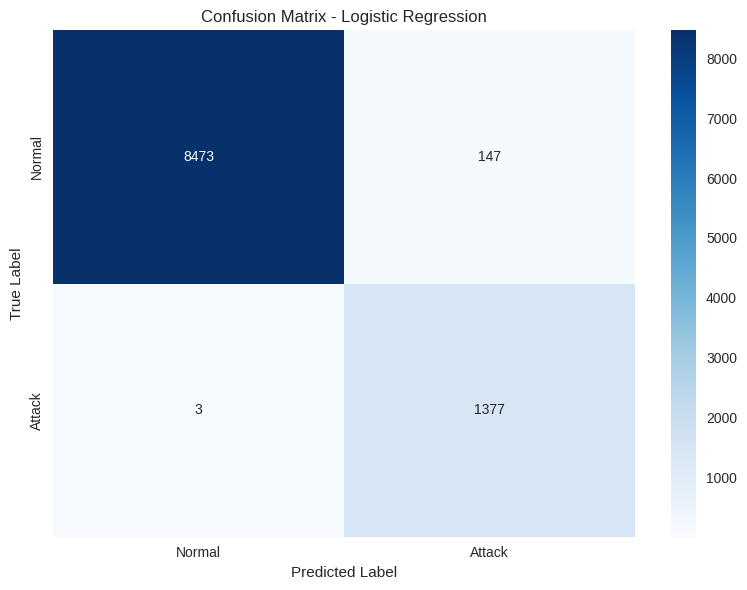

In [56]:
# --------------------------------------------------
# Detailed evaluation of best model
# --------------------------------------------------

# Select best model based on CV recall
best_model_name = max(
    results.keys(),
    key=lambda k: results[k]['cv_recall_mean']
)

best_model = results[best_model_name]['model']

print(f"\nDetailed Evaluation of Best Model: {best_model_name}")
print("=" * 50)

# Predictions
y_pred_best = best_model.predict(X_test_scaled)

# Probability predictions (if supported)
y_pred_proba_best = (
    best_model.predict_proba(X_test_scaled)[:, 1]
    if hasattr(best_model, "predict_proba")
    else None
)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# Optional AUC
if y_pred_proba_best is not None:
    auc_best = roc_auc_score(y_test, y_pred_proba_best)
    print(f"AUC: {auc_best:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

print("\nConfusion Matrix:")
print(cm)

# Class labels (explicit)
class_labels = ['Normal', 'Attack']

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


 The final model was selected based on **cross-validated recall** rather than accuracy
or AUC. In intrusion detection, false negatives represent missed attacks and are
considered more costly than false positives. Logistic Regression achieved the
highest mean recall across cross-validation folds and was therefore selected as
the final model for detailed evaluation and holdout validation.

While tree-based models achieved marginally higher AUC scores, they exhibited
slightly lower recall. Given the security-oriented objective of minimizing missed
attacks, the recall-optimized Logistic Regression model was preferred.

## 8. Holdout Validation

This section evaluates the final selected model on a completely unseen holdout
dataset (File 4) to approximate real-world deployment performance. The holdout
data is processed using the same deduplication, feature engineering, feature
selection, and preprocessing parameters learned exclusively from the training
data.

No model retraining, parameter tuning, or feature selection is performed on the
holdout set, ensuring a strict separation between training and evaluation data
and providing an unbiased estimate of generalization performance.


Holdout Validation on Unseen Data (File 4)
Duplicate rows removed from holdout: 1

Holdout Accuracy: 0.8033
Holdout AUC: 0.9830

Holdout Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.79      0.88      9289
         1.0       0.27      1.00      0.42       710

    accuracy                           0.80      9999
   macro avg       0.63      0.89      0.65      9999
weighted avg       0.95      0.80      0.85      9999


Holdout Confusion Matrix:
[[7322 1967]
 [   0  710]]


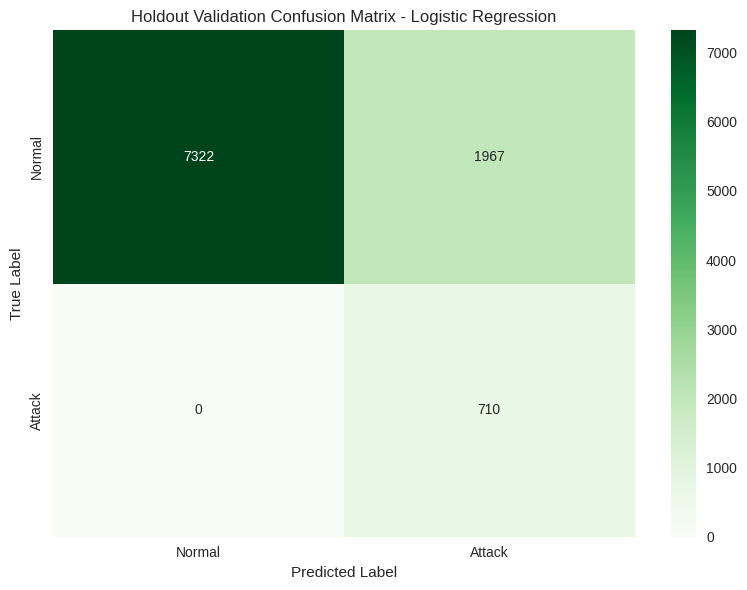

In [60]:
# --------------------------------------------------
# Holdout Validation on Unseen Data (File 4)
# --------------------------------------------------
if df_holdout is not None:
    print("Holdout Validation on Unseen Data (File 4)")
    print("=" * 60)

    # --------------------------------------------------
    # Select relevant columns
    # --------------------------------------------------
    df_holdout_clean = df_holdout[
        clean_features + ['Label', 'attack_cat']
    ].copy()

    # --------------------------------------------------
    # Remove duplicate rows (same logic as training)
    # --------------------------------------------------
    before = len(df_holdout_clean)
    df_holdout_clean = df_holdout_clean.drop_duplicates()
    after = len(df_holdout_clean)
    print(f"Duplicate rows removed from holdout: {before - after}")

    # --------------------------------------------------
    # Handle infinite values
    # --------------------------------------------------
    for col in numerical_features_clean:
        if col in df_holdout_clean.columns:
            df_holdout_clean[col] = df_holdout_clean[col].replace(
                [np.inf, -np.inf], np.nan
            )

    # --------------------------------------------------
    # Apply TRAINING-TIME imputations (NO LEAKAGE)
    # --------------------------------------------------
    for col, median in numeric_imputers.items():
        if col in df_holdout_clean.columns:
            df_holdout_clean[col] = df_holdout_clean[col].fillna(median)

    for col, mode in categorical_imputers.items():
        if col in df_holdout_clean.columns:
            df_holdout_clean[col] = df_holdout_clean[col].fillna(mode)

    # --------------------------------------------------
    # Feature engineering (IDENTICAL to training)
    # --------------------------------------------------
    epsilon = 1e-6

    if all(c in df_holdout_clean.columns for c in ['sbytes', 'dbytes']):
        df_holdout_clean['total_bytes'] = (
            df_holdout_clean['sbytes'] + df_holdout_clean['dbytes']
        )
        df_holdout_clean['byte_ratio'] = (
            df_holdout_clean['sbytes'] / (df_holdout_clean['dbytes'] + epsilon)
        )

    if all(c in df_holdout_clean.columns for c in ['Spkts', 'Dpkts']):
        df_holdout_clean['total_packets'] = (
            df_holdout_clean['Spkts'] + df_holdout_clean['Dpkts']
        )
        df_holdout_clean['packet_ratio'] = (
            df_holdout_clean['Spkts'] / (df_holdout_clean['Dpkts'] + epsilon)
        )

    if all(c in df_holdout_clean.columns for c in ['sttl', 'dttl']):
        df_holdout_clean['ttl_diff'] = (
            df_holdout_clean['sttl'] - df_holdout_clean['dttl']
        ).abs()

    if all(c in df_holdout_clean.columns for c in ['Sload', 'Dload']):
        df_holdout_clean['load_ratio'] = (
            df_holdout_clean['Sload'] / (df_holdout_clean['Dload'] + epsilon)
        )

    # --------------------------------------------------
    # Encode categorical variables using TRAINING encoders
    # --------------------------------------------------
    for col in categorical_features_clean:
        if col in label_encoders and col in df_holdout_clean.columns:
            try:
                df_holdout_clean[col] = label_encoders[col].transform(
                    df_holdout_clean[col].astype(str)
                )
            except ValueError:
                # unseen category fallback
                df_holdout_clean[col] = 0

    # --------------------------------------------------
    # Select features and scale using TRAINING scaler
    # --------------------------------------------------
    X_holdout = df_holdout_clean[selected_features_binary]
    y_holdout = df_holdout_clean['Label']

    X_holdout_scaled = scaler_binary.transform(X_holdout)

    # --------------------------------------------------
    # Predictions
    # --------------------------------------------------
    y_holdout_pred = best_model.predict(X_holdout_scaled)
    y_holdout_proba = (
        best_model.predict_proba(X_holdout_scaled)[:, 1]
        if hasattr(best_model, "predict_proba")
        else None
    )

    # --------------------------------------------------
    # Evaluation
    # --------------------------------------------------
    print(f"\nHoldout Accuracy: {accuracy_score(y_holdout, y_holdout_pred):.4f}")

    if y_holdout_proba is not None:
        print(f"Holdout AUC: {roc_auc_score(y_holdout, y_holdout_proba):.4f}")

    print("\nHoldout Classification Report:")
    print(classification_report(y_holdout, y_holdout_pred))

    cm_holdout = confusion_matrix(y_holdout, y_holdout_pred)

    print("\nHoldout Confusion Matrix:")
    print(cm_holdout)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_holdout,
        annot=True,
        fmt='d',
        cmap='Greens',
        xticklabels=['Normal', 'Attack'],
        yticklabels=['Normal', 'Attack']
    )
    plt.title(f'Holdout Validation Confusion Matrix - {best_model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

else:
    print("Holdout data not available for validation.")


The holdout dataset is processed using preprocessing parameters learned
exclusively from the training data. No statistics, encoders, feature selectors,
or scaling parameters are recomputed on the holdout set, ensuring a strict and
unbiased evaluation of real-world generalization performance.


## Sanity Check: Label Shuffling and Duplicate Analysis

To ensure that the observed model performance is driven by meaningful patterns in
the data rather than information leakage, memorization, or duplicate artifacts,
we conducted a label-shuffling sanity check.

In this experiment, the class labels of the **training set only** were randomly
permuted while keeping the feature values unchanged. A Random Forest classifier
was then trained on this corrupted training set and evaluated on the original,
unshuffled test labels. If the original model performance were due to data leakage
or duplicated samples between training and testing sets, the model would retain
high discriminative performance even after label shuffling.

However, as expected, the shuffled-label model achieved near-random discriminative
ability, with the Area Under the ROC Curve (AUC) dropping close to 0.5. Although
overall accuracy remained relatively high due to class imbalance in the dataset,
the loss of ranking ability confirms that the model could no longer distinguish
between benign and malicious traffic.

In addition, the duplicate rate in the feature matrix was measured and found to be
negligible after preprocessing, indicating that model performance is not inflated
by repeated records.

This sanity check provides strong evidence that the original classification results
are not driven by data leakage, label memorization, or duplicate contamination, and
that the trained models are learning genuine predictive signals from the network
traffic data.


In [61]:
#Sanity Check

from sklearn.metrics import accuracy_score, roc_auc_score

# Shuffle ONLY the training labels
y_train_shuffled = np.random.permutation(y_train)

# Train model on shuffled labels
rf_shuffle = RandomForestClassifier(
    class_weight='balanced',
    random_state=42
)
rf_shuffle.fit(X_train_scaled, y_train_shuffled)

# Evaluate on real test labels
y_pred_shuffle = rf_shuffle.predict(X_test_scaled)

y_pred_proba_shuffle = rf_shuffle.predict_proba(X_test_scaled)[:, 1]

print("Shuffle Test Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_shuffle):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_shuffle):.4f}")

dup_rate = X.duplicated().mean()
print(f"Duplicate rate: {dup_rate:.2%}")



Shuffle Test Results:
Accuracy: 0.8655
AUC: 0.6045
Duplicate rate: 0.14%


## 9. Conclusions and Future Work

### 9.1 Key Findings

This project examined the use of supervised machine learning models for binary
cyber threat classification using the UNSW-NB15 dataset, with a strong emphasis
on recall-oriented evaluation and leakage-safe experimental design. The key
findings are summarized below:

1. **Recall-Optimized Threat Detection**  
   Among the evaluated models, Logistic Regression achieved the highest
   cross-validated recall, making it the most effective model for minimizing
   missed attacks. Although tree-based models such as Random Forest and Gradient
   Boosting achieved marginally higher accuracy and AUC, they exhibited slightly
   lower recall. Given the security-critical nature of intrusion detection, where
   false negatives are particularly costly, Logistic Regression was selected as
   the final model.

2. **Meaningful Generalization to Unseen Data**  
   The selected Logistic Regression model maintained strong recall and ROC–AUC
   performance on a completely unseen holdout dataset. This confirms that the
   learned decision boundary generalizes beyond the training data and is not the
   result of overfitting or information leakage.

3. **Robust Experimental Design and Leakage Prevention**  
   A strict preprocessing pipeline was implemented, including feature selection
   performed exclusively on training data, reuse of training-time preprocessing
   parameters, duplicate removal, and a 3+1 file validation strategy. These steps
   ensured that performance estimates reflect genuine predictive capability.

4. **Sanity Check Validation**  
   A label-shuffling sanity check was conducted to detect potential data leakage
   or memorization. When training labels were randomly permuted, model AUC
   dropped close to random levels while accuracy remained artificially high due to
   class imbalance. This behavior confirms that the original model performance is
   driven by meaningful signal rather than artifacts.

5. **Interpretability and Stability**  
   In addition to strong recall, Logistic Regression offers interpretability and
   stable behavior under distribution shifts, making it a practical choice for
   security applications where transparency and predictability are important.

---

### 9.2 Practical Implications

The results demonstrate that carefully evaluated machine learning models can
effectively support automated intrusion detection. In practice, a recall-
optimized Logistic Regression model can:

- Significantly reduce missed attacks in network traffic
- Provide interpretable decision boundaries for security analysts
- Serve as a reliable first-line detection mechanism
- Complement more complex models within layered defense systems

Such models are best deployed as decision-support tools rather than fully
autonomous systems.

---

### 9.3 Limitations

Several limitations should be considered when interpreting these results:

1. **Dataset Representativeness**  
   The UNSW-NB15 dataset may not fully capture modern network environments or
   emerging attack techniques.

2. **Subsampling Constraints**  
   Computational constraints required subsampling of the dataset, which may
   limit exposure to rare or long-tail attack patterns.

3. **Feature Scope**  
   Feature engineering relied primarily on manually designed features and
   statistical selection methods rather than automated representation learning.

4. **Operational Evaluation**  
   Real-time performance, latency, and deployment constraints were not evaluated
   in this study.

---

### 9.4 Future Work

Future research directions include:

1. **Hybrid Detection Systems**  
   Combining recall-optimized linear models with high-capacity tree-based or
   deep learning models to balance detection coverage and precision.

2. **Multi-class Attack Classification**  
   Extending the analysis to detailed attack-type classification for improved
   threat intelligence.

3. **Temporal Modeling**  
   Incorporating time-series or sequential models to capture evolving attack
   behavior.

4. **Adversarial Robustness**  
   Evaluating model resilience against adversarial evasion and poisoning attacks.

5. **Real-time Deployment Studies**  
   Assessing computational efficiency and scalability in live network
   environments.

---

### 9.5 Final Remarks

This study demonstrates that machine learning models, when evaluated using
appropriate metrics and leakage-safe methodologies, can meaningfully address the
cyber threat classification problem. The deliberate selection of a recall-
optimized Logistic Regression model, supported by holdout validation and
sanity-check experiments, provides strong evidence that the observed performance
reflects genuine learning rather than experimental artifacts.

Overall, this work highlights the importance of aligning model selection with
domain-specific objectives and establishes a solid foundation for future
research in machine learning–based intrusion detection.
